# ACML Assignment 2 Ben Beisser I6336899 

## Readme

To run code on GPU with colab (if available):
- Click Runtime
- Click Change runtime type
- Choose T4 GPU (Python 3)

The following code should be device agnostic and therefore use cuda if available to move models and data to the GPU

In [1]:
!nvidia-smi

Sun Nov 19 16:26:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets

from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split, ConcatDataset

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib import transforms

import cv2

import scipy.misc
from scipy import ndimage

from tqdm.auto import tqdm

In [3]:
torch.cuda.is_available()

True

In [4]:
# Setup device acgnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
BATCH_SIZE = 1024

## 1.1 Create Training Data and Normalization
At the beginning of the assignment it is crucial to create appropiate datasets and handle the input format with normalization of the data. We can load the cifar10 dataset directly from pytorch.datasets. The images are of the shape 32x32x3 where 3 denotes the number of color channels (red, green, blue). Since the values for the color channels are integers (0-255) we have to normalize them to be in the range of 0-1. We split the data according to the specifications given by the task (80%/10%,10%). Further, it is to note that we need all values as float32 values to prevent mismatches later on. Also we configure permutations of the datasets because pytorch for computer vision expects the number of color channels before the image size which differs from other frameworks and also from plotting images as numpy arrays. We also implement dataloaders to iterate them while training the network.

In [6]:
import torchvision.transforms as transform
from torchvision.transforms import ToTensor
# Load CIFAR-10 dataset
transform = transform.Compose([transform.ToTensor(), transform.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cifar_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar_test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Concatenate and shuffle the data
x_all = np.concatenate((cifar_train_dataset.data, cifar_test_dataset.data))
y_all = np.concatenate((np.array(cifar_train_dataset.targets), np.array(cifar_test_dataset.targets)))

# Split the dataset into 80/10/10
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, train_size=0.8, test_size=0.2, random_state=42)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, train_size=0.5, test_size=0.5, random_state=42)

# Turning the integer value to floats
x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_test = x_test.astype('float32')

y_train = y_train.astype('float32')
y_valid = y_valid.astype('float32')
y_test = y_test.astype('float32')

# Convert NumPy arrays to PyTorch tensors
x_train_tensor = torch.from_numpy(x_train).permute(0, 3, 1, 2) / 255.0
y_train_tensor = torch.from_numpy(y_train)

x_valid_tensor = torch.from_numpy(x_valid).permute(0, 3, 1, 2) / 255.0
y_valid_tensor = torch.from_numpy(y_valid)

x_test_tensor = torch.from_numpy(x_test).permute(0, 3, 1, 2) / 255.0
y_test_tensor = torch.from_numpy(y_test)

print(f'X shape: {x_train_tensor.shape}\nY shape: {y_train_tensor.shape}')

# Example usage
train_dataset = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
valid_dataset = torch.utils.data.TensorDataset(x_valid_tensor, y_valid_tensor)
test_dataset = torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor)

# Create DataLoader for training, validation, and test sets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


100%|██████████| 170498071/170498071 [00:03<00:00, 47480303.23it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
X shape: torch.Size([48000, 3, 32, 32])
Y shape: torch.Size([48000])


In [7]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        # First conv-pool block
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Second conv-pool block
        self.conv2 = nn.Conv2d(8, 12, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Third conv-pool block
        self.conv3 = nn.Conv2d(12, 16, kernel_size=3, stride=1, padding=1)

        # Upsampling layer
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

        # Fourth conv-pool block
        self.conv4 = nn.Conv2d(16, 12, kernel_size=3, stride=1, padding=1)

        # Upsampling layer
        self.upsample2 = nn.Upsample(scale_factor=2, mode='nearest')

        # Fifth conv-pool block
        self.conv5 = nn.Conv2d(12, 3, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        # Encoder
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))


        # Decoder
        x = self.upsample(x)
        x = F.relu(self.conv4(x))
        x = self.upsample2(x)
        x = F.relu(self.conv5(x))

        return x

# Instantiate the model
model_0 = ConvAutoencoder().to(device)


In [8]:
# Check if model is on GPU
next(model_0.parameters()).device

device(type='cuda', index=0)

In [9]:
# Define the loss function, accuracy and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model_0.parameters(), lr=0.001)

## 1.2 Implementing and training the network
The second step of the assignment is the implementation of the network according to the given specification and the training of the model. The model is constructed as specified in the task and further we use Mean Squared Error as the loss function and the Adam optimizer with learning rate 0.001. We train the model for 20 epochs and use device agnostic code for GPU usage when possible for the whole assignment. It is worth mentioning that we use a random seed for training to ensure similar results when rerunning the notebook.

After 20 epochs we achieve a training loss of 0.0074 and 0.0073 for test loss. We can see from the plot of the loss curves that we reach a fast decrease of the loss at the beginning of the training and fast convergence.

In [10]:
torch.manual_seed(42)
epochs = 20

train_losses = []
test_losses = []

# Create training and test loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-------")
  ### Training
  train_loss = 0
  # Add a loop to loop through the training batches
  for batch, (X, _)in enumerate(train_loader):
    X = X.to(device)
    model_0.train()
    # 1. forward pass
    reconstructed = model_0(X)

    # 2. Calculate loss (batch)
    loss = criterion(reconstructed, X)
    train_loss += loss.item() #  accumulate train loss

    # 3. optimizer zero grad
    optimizer.zero_grad()

    # 4. loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Print out
    if batch % 200 == 0:
      print(f"Looked at {batch * len(X)}/{len(train_loader.dataset)} samples.")
  # Divide total train loss by length of train dataloader
  train_loss /= len(train_loader)
  train_losses.append(train_loss)



### Testing
  test_loss = 0
  model_0.eval()
  with torch.inference_mode():
    for X_test, _ in test_loader:
      X_test = X_test.to(device)
      # 1. Forward pass
      test_reconstructed = model_0(X_test)


      # 2. Calculate loss (accumulatively)
      test_loss += criterion(test_reconstructed, X_test).item()

    # Calculate the test loss average per batch
    test_loss /= len(test_loader)
    test_losses.append(test_loss)

  # Print
  print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/48000 samples.

Train loss: 0.0840 | Test loss: 0.0299
Epoch: 1
-------
Looked at 0/48000 samples.

Train loss: 0.0228 | Test loss: 0.0188
Epoch: 2
-------
Looked at 0/48000 samples.

Train loss: 0.0174 | Test loss: 0.0164
Epoch: 3
-------
Looked at 0/48000 samples.

Train loss: 0.0154 | Test loss: 0.0145
Epoch: 4
-------
Looked at 0/48000 samples.

Train loss: 0.0131 | Test loss: 0.0115
Epoch: 5
-------
Looked at 0/48000 samples.

Train loss: 0.0108 | Test loss: 0.0104
Epoch: 6
-------
Looked at 0/48000 samples.

Train loss: 0.0100 | Test loss: 0.0097
Epoch: 7
-------
Looked at 0/48000 samples.

Train loss: 0.0094 | Test loss: 0.0093
Epoch: 8
-------
Looked at 0/48000 samples.

Train loss: 0.0091 | Test loss: 0.0090
Epoch: 9
-------
Looked at 0/48000 samples.

Train loss: 0.0088 | Test loss: 0.0087
Epoch: 10
-------
Looked at 0/48000 samples.

Train loss: 0.0086 | Test loss: 0.0085
Epoch: 11
-------
Looked at 0/48000 samples.

Train loss: 0.0084 | Test los

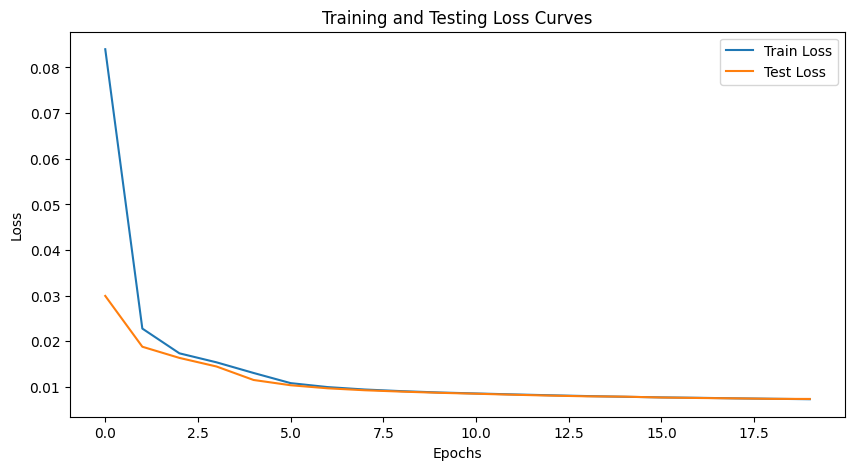

In [11]:
# Plotting the curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Testing Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

We further plot the reconstructed image from the network with the ground truth image from the dataset. We can see that our network does a fairly good job of reconstructing the original input. However, it is more blurry than the original which indicates that our network still can not perfectly recreate the input images. This can be due to the network architecture as well as the amount of training examples.

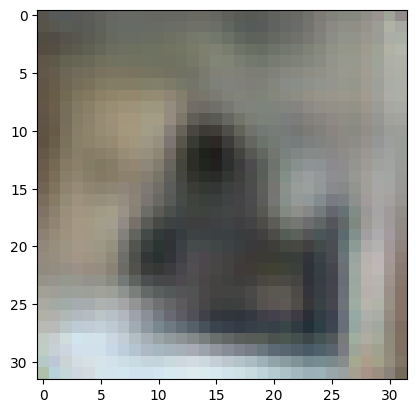

In [12]:
# plot reconstructed image
test_reconstructed_cpu = test_reconstructed.cpu().data.numpy()
plt.imshow(ndimage.rotate(test_reconstructed_cpu[0].T, 270))

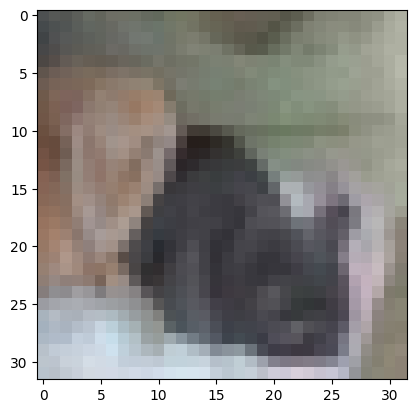

In [13]:
# Plot original test image
X_test_cpu = X_test.cpu().data.numpy()
plt.imshow(ndimage.rotate(X_test_cpu[0].T, 270))

In [14]:
torch.manual_seed(42)

val_losses = []
loss = 0
model_0.eval()
with torch.inference_mode():
  for X, _ in tqdm(valid_loader):
    X = X.to(device)
    # Make predictions
    y_pred = model_0(X)

    # Accumulate the loss values per batch
    loss += criterion(y_pred, X)

  # Scale loss and acc to find the average loss per batch
  loss /= len(valid_loader)
  val_losses.append(loss.item())

print(f'Model name: {model_0.__class__.__name__}\nModel loss: {loss.item()}')

  0%|          | 0/6 [00:00<?, ?it/s]

Model name: ConvAutoencoder
Model loss: 0.007363855838775635


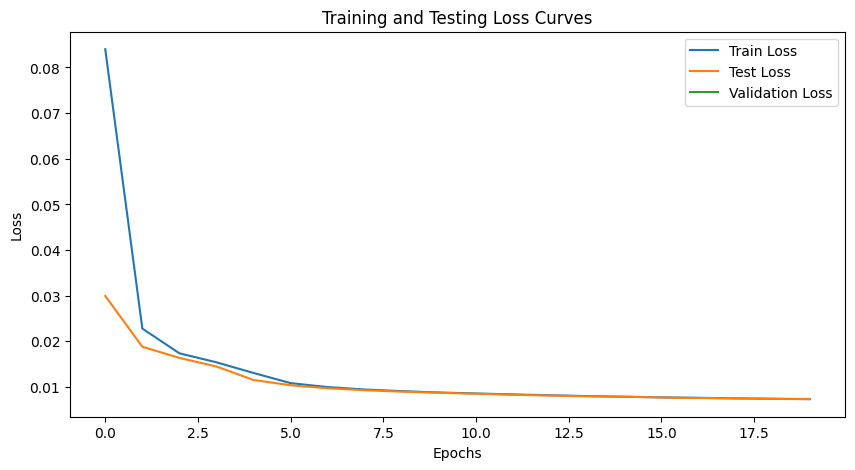

In [15]:
# Plotting the curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Testing Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 2.1 Size of latent space representation
we are further asked to access the size of the latent space of the network we created. According to the formula given in the assignment we can see that the network specified above has a size of the latent space representation of 2304.

In [16]:
# Calculating size of convolutional layer
# W = Input voulume, K = kernel size, P = Padding, S = Stride, C = Number of channels
def size_conv_layer(W, K, P, S, C):
  return (((W-K+2*P/S)+1)**2)*C

size_latent_space = size_conv_layer(12, 3, 1, 1, 16)
print(f'Size of latent space model_0: {size_latent_space}')

Size of latent space model_0: 2304.0


## 2.2 Further Architecture
In the following we will experiment with different architectures and investigate the influence of different number of layers, different number of channels, and differnet filter and padding configuration on the reconstruction error. Our second model is represented by just two convolutional layers in the encoder part and one convolutional layer in the decoder. The third model has the same architecture as the original network but the input channel sizes are doubled. The fourth model has again the same layers as the original model but a different combination in filter sizes. The results and sizes of the latent space representation are discussed in a later section of the report.

In [17]:
# Creating model with fewer intermediate layers
class ConvAutoencoderReduced(nn.Module):
  def __init__(self):
    super(ConvAutoencoderReduced, self).__init__()

    # First conv-pool block
    self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    # Second conv-pool block
    self.conv2 = nn.Conv2d(8, 12, kernel_size=3, stride=1, padding=1)
    # Removed the second max pooling layer

    # Upsampling layer
    self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

    # Third conv-pool block (Note: Adjusted channels for compatibility)
    self.conv3 = nn.Conv2d(12, 3, kernel_size=3, stride=1, padding=1)


  def forward(self, x):
    # Encoder
    x = F.relu(self.conv1(x))
    x = self.pool1(x)
    x = F.relu(self.conv2(x))

    # Decoder
    x = self.upsample(x)
    x = F.relu(self.conv3(x))

    return x

model_1 = ConvAutoencoderReduced().to(device)

In [18]:
# Check if model is on GPU
next(model_1.parameters()).device

device(type='cuda', index=0)

In [19]:
# Define the loss function, accuracy and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model_1.parameters(), lr=0.001)

In [20]:
torch.manual_seed(42)
epochs = 20

train_losses = []
test_losses = []

# Create training and test loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-------")
  ### Training
  train_loss = 0
  # Add a loop to loop through the training batches
  for batch, (X, _)in enumerate(train_loader):
    X = X.to(device)
    model_1.train()
    # 1. forward pass
    reconstructed = model_1(X)

    # 2. Calculate loss (batch)
    loss = criterion(reconstructed, X)
    train_loss += loss.item() #  accumulate train loss

    # 3. optimizer zero grad
    optimizer.zero_grad()

    # 4. loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Print out
    if batch % 200 == 0:
      print(f"Looked at {batch * len(X)}/{len(train_loader.dataset)} samples.")
  # Divide total train loss by length of train dataloader
  train_loss /= len(train_loader)
  train_losses.append(train_loss)



### Testing
  test_loss = 0
  model_1.eval()
  with torch.inference_mode():
    for X_test, _ in test_loader:
      X_test = X_test.to(device)
      # 1. Forward pass
      test_reconstructed = model_1(X_test)


      # 2. Calculate loss (accumulatively)
      test_loss += criterion(test_reconstructed, X_test).item()

    # Calculate the test loss average per batch
    test_loss /= len(test_loader)
    test_losses.append(test_loss)

  # Print
  print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/48000 samples.

Train loss: 0.0679 | Test loss: 0.0349
Epoch: 1
-------
Looked at 0/48000 samples.

Train loss: 0.0239 | Test loss: 0.0139
Epoch: 2
-------
Looked at 0/48000 samples.

Train loss: 0.0099 | Test loss: 0.0075
Epoch: 3
-------
Looked at 0/48000 samples.

Train loss: 0.0066 | Test loss: 0.0060
Epoch: 4
-------
Looked at 0/48000 samples.

Train loss: 0.0055 | Test loss: 0.0052
Epoch: 5
-------
Looked at 0/48000 samples.

Train loss: 0.0049 | Test loss: 0.0047
Epoch: 6
-------
Looked at 0/48000 samples.

Train loss: 0.0044 | Test loss: 0.0043
Epoch: 7
-------
Looked at 0/48000 samples.

Train loss: 0.0041 | Test loss: 0.0040
Epoch: 8
-------
Looked at 0/48000 samples.

Train loss: 0.0039 | Test loss: 0.0038
Epoch: 9
-------
Looked at 0/48000 samples.

Train loss: 0.0037 | Test loss: 0.0036
Epoch: 10
-------
Looked at 0/48000 samples.

Train loss: 0.0035 | Test loss: 0.0035
Epoch: 11
-------
Looked at 0/48000 samples.

Train loss: 0.0034 | Test los

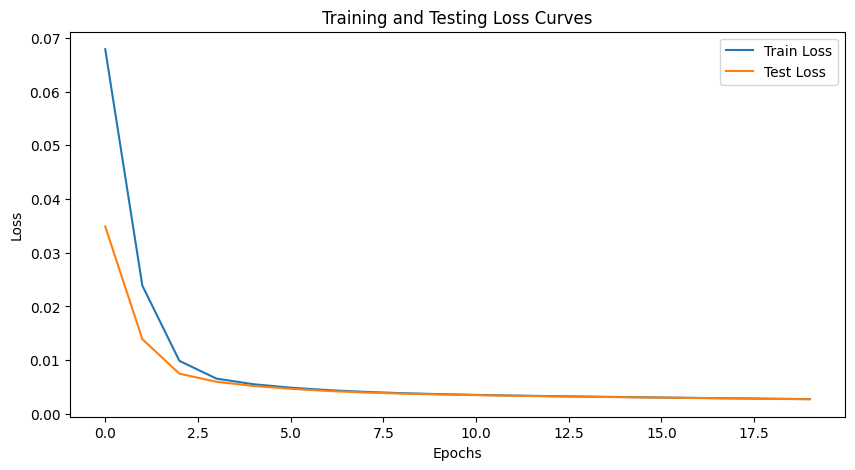

In [21]:
# Plotting the curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Testing Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

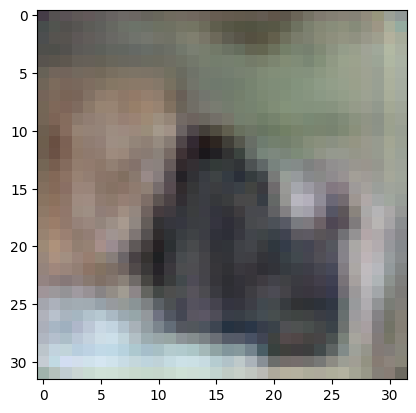

In [22]:
# plot reconstructed image
test_reconstructed_cpu = test_reconstructed.cpu().data.numpy()
plt.imshow(ndimage.rotate(test_reconstructed_cpu[0].T, 270))

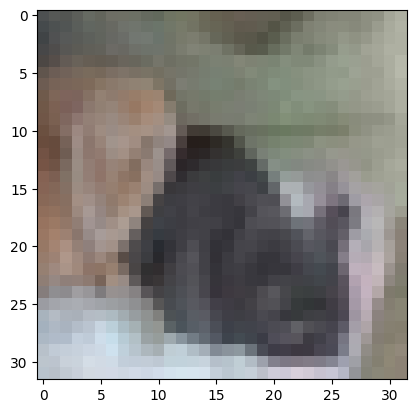

In [23]:
# Plot original test image
X_test_cpu = X_test.cpu().data.numpy()
plt.imshow(ndimage.rotate(X_test_cpu[0].T, 270))

In [24]:
torch.manual_seed(42)

val_losses = []
loss = 0
model_1.eval()
with torch.inference_mode():
  for X, _ in tqdm(valid_loader):
    X = X.to(device)
    # Make predictions
    y_pred = model_1(X)

    # Accumulate the loss values per batch
    loss += criterion(y_pred, X)

  # Scale loss and acc to find the average loss per batch
  loss /= len(valid_loader)
  val_losses.append(loss.item())

print(f'Model name: {model_1.__class__.__name__}\nModel loss: {loss.item()}')

  0%|          | 0/6 [00:00<?, ?it/s]

Model name: ConvAutoencoderReduced
Model loss: 0.0027485813479870558


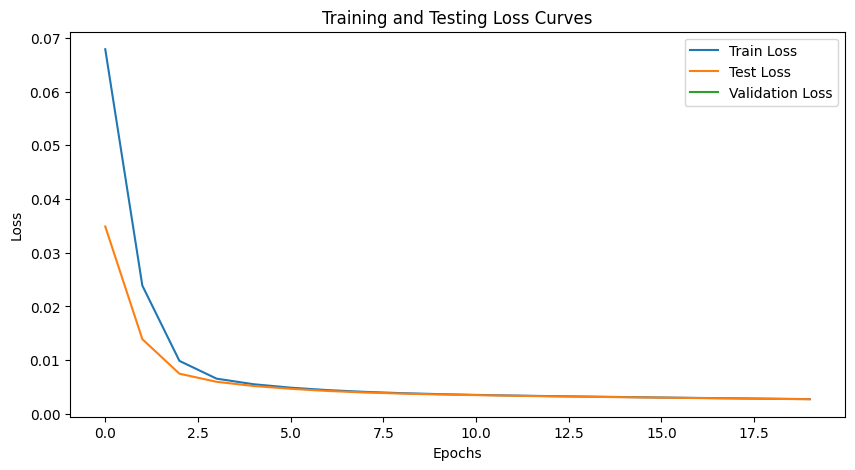

In [25]:
# Plotting the curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Testing Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
# Calculating size of convolutional layer

size_latent_space = size_conv_layer(8, 3, 1, 1, 12)
print(f'Size of latent space model_1: {size_latent_space}')

Size of latent space model_1: 768.0


## Third model


In [27]:
# Third model with different number of channels
class ConvAutoencoderChannels(nn.Module):
    def __init__(self):
        super(ConvAutoencoderChannels, self).__init__()

        # First conv-pool block
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Second conv-pool block
        self.conv2 = nn.Conv2d(16, 24, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Third conv-pool block
        self.conv3 = nn.Conv2d(24, 32, kernel_size=3, stride=1, padding=1)

        # Upsampling layer
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

        # Fourth conv-pool block
        self.conv4 = nn.Conv2d(32, 24, kernel_size=3, stride=1, padding=1)

        # Upsampling layer
        self.upsample2 = nn.Upsample(scale_factor=2, mode='nearest')

        # Fifth conv-pool block
        self.conv5 = nn.Conv2d(24, 3, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        # Encoder
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))


        # Decoder
        x = self.upsample(x)
        x = F.relu(self.conv4(x))
        x = self.upsample2(x)
        x = F.relu(self.conv5(x))

        return x

# Instantiate the model
model_2 = ConvAutoencoderChannels().to(device)

In [28]:
# Check if model is on GPU
next(model_2.parameters()).device

device(type='cuda', index=0)

In [29]:
# Define the loss function, accuracy and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model_2.parameters(), lr=0.001)

In [30]:
torch.manual_seed(42)
epochs = 20

train_losses = []
test_losses = []

# Create training and test loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-------")
  ### Training
  train_loss = 0
  # Add a loop to loop through the training batches
  for batch, (X, _)in enumerate(train_loader):
    X = X.to(device)
    model_2.train()
    # 1. forward pass
    reconstructed = model_2(X)

    # 2. Calculate loss (batch)
    loss = criterion(reconstructed, X)
    train_loss += loss.item() #  accumulate train loss

    # 3. optimizer zero grad
    optimizer.zero_grad()

    # 4. loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Print out
    if batch % 200 == 0:
      print(f"Looked at {batch * len(X)}/{len(train_loader.dataset)} samples.")
  # Divide total train loss by length of train dataloader
  train_loss /= len(train_loader)
  train_losses.append(train_loss)



### Testing
  test_loss = 0
  model_2.eval()
  with torch.inference_mode():
    for X_test, _ in test_loader:
      X_test = X_test.to(device)
      # 1. Forward pass
      test_reconstructed = model_2(X_test)


      # 2. Calculate loss (accumulatively)
      test_loss += criterion(test_reconstructed, X_test).item()

    # Calculate the test loss average per batch
    test_loss /= len(test_loader)
    test_losses.append(test_loss)

  # Print
  print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/48000 samples.

Train loss: 0.1809 | Test loss: 0.1106
Epoch: 1
-------
Looked at 0/48000 samples.

Train loss: 0.1050 | Test loss: 0.1003
Epoch: 2
-------
Looked at 0/48000 samples.

Train loss: 0.0475 | Test loss: 0.0179
Epoch: 3
-------
Looked at 0/48000 samples.

Train loss: 0.0152 | Test loss: 0.0139
Epoch: 4
-------
Looked at 0/48000 samples.

Train loss: 0.0107 | Test loss: 0.0095
Epoch: 5
-------
Looked at 0/48000 samples.

Train loss: 0.0089 | Test loss: 0.0084
Epoch: 6
-------
Looked at 0/48000 samples.

Train loss: 0.0081 | Test loss: 0.0077
Epoch: 7
-------
Looked at 0/48000 samples.

Train loss: 0.0074 | Test loss: 0.0071
Epoch: 8
-------
Looked at 0/48000 samples.

Train loss: 0.0069 | Test loss: 0.0069
Epoch: 9
-------
Looked at 0/48000 samples.

Train loss: 0.0066 | Test loss: 0.0064
Epoch: 10
-------
Looked at 0/48000 samples.

Train loss: 0.0064 | Test loss: 0.0063
Epoch: 11
-------
Looked at 0/48000 samples.

Train loss: 0.0062 | Test los

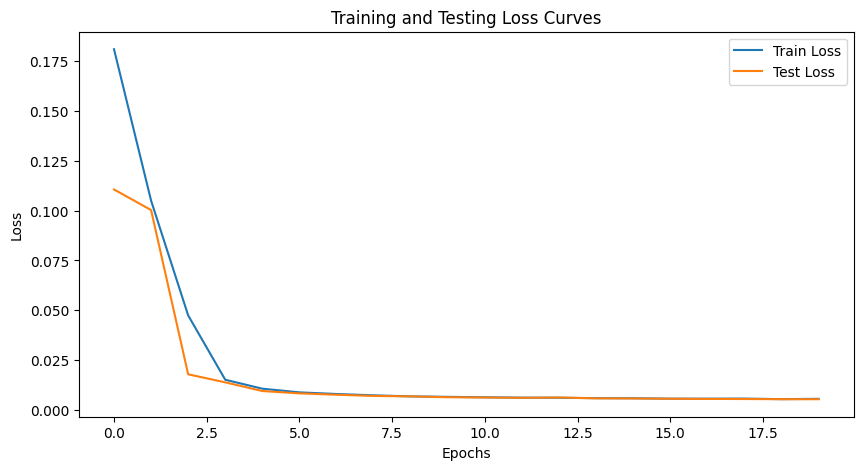

In [31]:
# Plotting the curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Testing Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

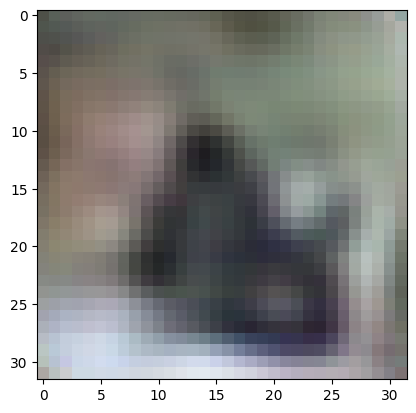

In [32]:
# plot reconstructed image
test_reconstructed_cpu = test_reconstructed.cpu().data.numpy()
plt.imshow(ndimage.rotate(test_reconstructed_cpu[0].T, 270))

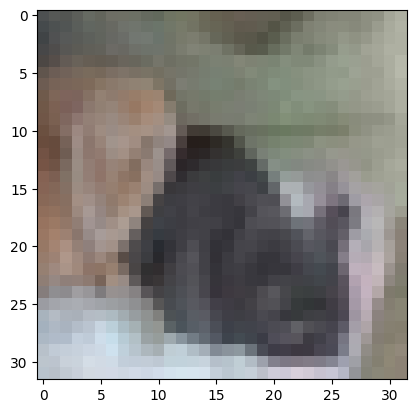

In [33]:
# Plot original test image
X_test_cpu = X_test.cpu().data.numpy()
plt.imshow(ndimage.rotate(X_test_cpu[0].T, 270))

In [34]:
torch.manual_seed(42)

val_losses = []
loss = 0
model_2.eval()
with torch.inference_mode():
  for X, _ in tqdm(valid_loader):
    X = X.to(device)
    # Make predictions
    y_pred = model_2(X)

    # Accumulate the loss per batch
    loss += criterion(y_pred, X)

  # Scale loss and acc to find the average loss per batch
  loss /= len(valid_loader)
  val_losses.append(loss.item())

print(f'Model name: {model_2.__class__.__name__}\nModel loss: {loss.item()}')

  0%|          | 0/6 [00:00<?, ?it/s]

Model name: ConvAutoencoderChannels
Model loss: 0.005469605326652527


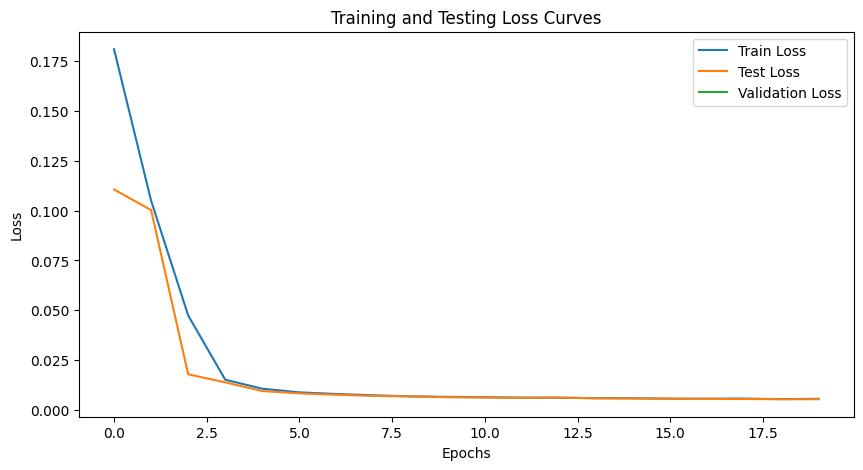

In [35]:
# Plotting the curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Testing Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [36]:
# Calculating size of convolutional layer

size_latent_space = size_conv_layer(24, 3, 1, 1, 32)
print(f'Size of latent space model_1: {size_latent_space}')

Size of latent space model_1: 18432.0


## Fourth model

In [37]:
# Fourth model with different filter size
class ConvAutoencoderKernel(nn.Module):
    def __init__(self):
        super(ConvAutoencoderKernel, self).__init__()

        # First conv-pool block
        self.conv1 = nn.Conv2d(3, 8, kernel_size=4, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Second conv-pool block
        self.conv2 = nn.Conv2d(8, 12, kernel_size=4, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Third conv-pool block
        self.conv3 = nn.Conv2d(12, 16, kernel_size=6, stride=1, padding=1)

        # Upsampling layer
        self.upsample = nn.Upsample(scale_factor=3, mode='nearest')

        # Fourth conv-pool block
        self.conv4 = nn.Conv2d(16, 12, kernel_size=4, stride=1, padding=1)

        # Upsampling layer
        self.upsample2 = nn.Upsample(scale_factor=3, mode='nearest')

        # Fifth conv-pool block
        self.conv5 = nn.Conv2d(12, 3, kernel_size=4, stride=1, padding=1)

    def forward(self, x):
        # Encoder
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))


        # Decoder
        x = self.upsample(x)
        x = F.relu(self.conv4(x))
        x = self.upsample2(x)
        x = F.relu(self.conv5(x))

        return x

# Instantiate the model
model_3 = ConvAutoencoderKernel().to(device)

In [38]:
# Check if model is on GPU
next(model_3.parameters()).device

device(type='cuda', index=0)

In [39]:
# Define the loss function, accuracy and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model_3.parameters(), lr=0.001)

In [40]:
torch.manual_seed(42)
epochs = 20

train_losses = []
test_losses = []

# Create training and test loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-------")
  ### Training
  train_loss = 0
  # Add a loop to loop through the training batches
  for batch, (X, _)in enumerate(train_loader):
    X = X.to(device)
    model_3.train()
    # 1. forward pass
    reconstructed = model_3(X)

    # 2. Calculate loss (batch)
    loss = criterion(reconstructed, X)
    train_loss += loss.item() #  accumulate train loss

    # 3. optimizer zero grad
    optimizer.zero_grad()

    # 4. loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Print out
    if batch % 200 == 0:
      print(f"Looked at {batch * len(X)}/{len(train_loader.dataset)} samples.")
  # Divide total train loss by length of train dataloader
  train_loss /= len(train_loader)
  train_losses.append(train_loss)



### Testing
  test_loss = 0
  model_3.eval()
  with torch.inference_mode():
    for X_test, _ in test_loader:
      X_test = X_test.to(device)
      # 1. Forward pass
      test_reconstructed = model_3(X_test)


      # 2. Calculate loss (accumulatively)
      test_loss += criterion(test_reconstructed, X_test).item()

    # Calculate the test loss average per batch
    test_loss /= len(test_loader)
    test_losses.append(test_loss)

  # Print
  print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/48000 samples.

Train loss: 0.1768 | Test loss: 0.1309
Epoch: 1
-------
Looked at 0/48000 samples.

Train loss: 0.1264 | Test loss: 0.1231
Epoch: 2
-------
Looked at 0/48000 samples.

Train loss: 0.1213 | Test loss: 0.1190
Epoch: 3
-------
Looked at 0/48000 samples.

Train loss: 0.1179 | Test loss: 0.1164
Epoch: 4
-------
Looked at 0/48000 samples.

Train loss: 0.0789 | Test loss: 0.0305
Epoch: 5
-------
Looked at 0/48000 samples.

Train loss: 0.0279 | Test loss: 0.0268
Epoch: 6
-------
Looked at 0/48000 samples.

Train loss: 0.0258 | Test loss: 0.0254
Epoch: 7
-------
Looked at 0/48000 samples.

Train loss: 0.0245 | Test loss: 0.0242
Epoch: 8
-------
Looked at 0/48000 samples.

Train loss: 0.0235 | Test loss: 0.0233
Epoch: 9
-------
Looked at 0/48000 samples.

Train loss: 0.0227 | Test loss: 0.0226
Epoch: 10
-------
Looked at 0/48000 samples.

Train loss: 0.0221 | Test loss: 0.0220
Epoch: 11
-------
Looked at 0/48000 samples.

Train loss: 0.0216 | Test los

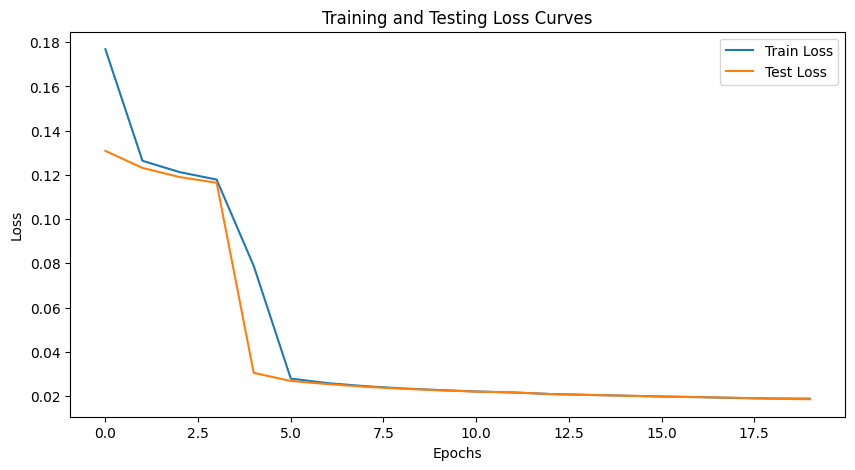

In [41]:
# Plotting the curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Testing Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

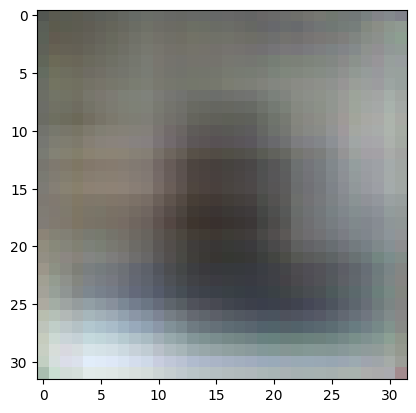

In [42]:
# plot reconstructed image
test_reconstructed_cpu = test_reconstructed.cpu().data.numpy()
plt.imshow(ndimage.rotate(test_reconstructed_cpu[0].T, 270))

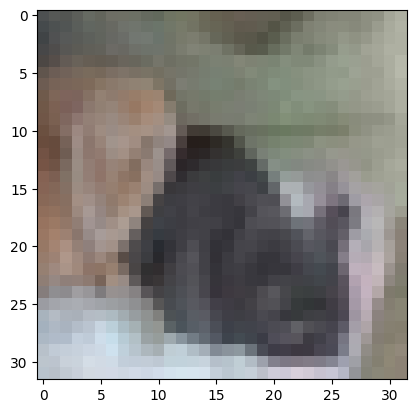

In [43]:
# Plot original test image
X_test_cpu = X_test.cpu().data.numpy()
plt.imshow(ndimage.rotate(X_test_cpu[0].T, 270))

In [44]:
torch.manual_seed(42)

val_losses = []
loss = 0
model_3.eval()
with torch.inference_mode():
  for X, _ in tqdm(valid_loader):
    X = X.to(device)
    # Make predictions
    y_pred = model_3(X)

    # Accumulate the loss values per batch
    loss += criterion(y_pred, X)

  # Scale loss and acc to find the average loss per batch
  loss /= len(valid_loader)
  val_losses.append(loss.item())

print(f'Model name: {model_3.__class__.__name__}\nModel loss: {loss.item()}')

  0%|          | 0/6 [00:00<?, ?it/s]

Model name: ConvAutoencoderKernel
Model loss: 0.0185081884264946


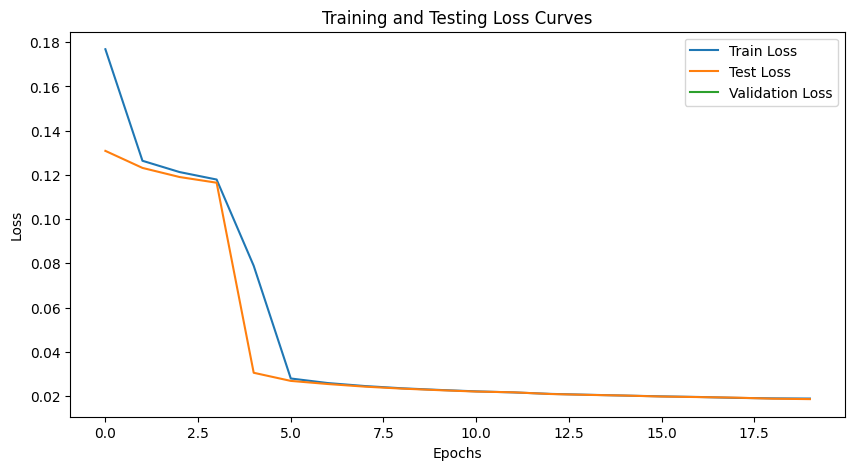

In [45]:
# Plotting the curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Testing Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [46]:
# Calculating size of convolutional layer
size_latent_space = size_conv_layer(12, 6, 1, 1, 16)
print(f'Size of latent space model_1: {size_latent_space}')

Size of latent space model_1: 1296.0


## Model comparison
In the following section the model results and the correlation between the errors and the latent space representation are discussed.

Model_0 (Original Model):
Training loss: 0.0074 Testing Loss: 0.0073 Latent Space size: 2304

Model_1 (Fewer Layers):
Training loss: 0.0028 Testing Loss: 0.0027 Latent Space size: 768

Model_2 (Doubled Channels):
Training loss: 0.0056 Testing Loss: 0.0054 Latent Space size: 18432

Model_3 (Different Filters):
Training loss: 0.0188 Testing Loss: 0.0186 Latent Space size: 1296

We can see that the second model with fewer layers reached the best performance regarding the error. This is also shown in the plot of the reconstructed image where the reconstruction of the second Model_1 is more accurate than the original. The latent space representation (768) is smaller as expected. The performance of Model_2 (Doubled channels) is between the original model and the model with fewer layers. This model has a much larger size of the latent space representation. This let us answer the second question of the exercise because we can see that there is no obvious correlation between the size of the latent space representation and the error. The fourth model (Diferent filters) shows the worst performance. This can also be seen in the reconstructed image which is very blurry and does not reflect the original input image accurately.


## Exercise 3 Colorization
In the third part we want to adapt our network architecture in a way that we can recreate rgb images from grayscale input images. First we have to load the data again and then transform the input images into grayscale. We will use the hint of the exercise that is it easier predict only the chrominance proportions of the images. Therefore, we will use this representation as the output data while training and then afterwards recreate the original rgb image.

In [82]:
# Gettin cifar10 dataset as grayscale and performing teh normalization and splits seen before
import torchvision.transforms as transform
from torchvision.transforms import ToTensor
# Load CIFAR-10 dataset
transform = transform.Compose([
    transform.Grayscale(num_output_channels=1),
    transform.ToTensor()])  #(0.5, 0.5, 0.5), (0.5, 0.5, 0.5) ,transform.Normalize((0.5,), (0.5,))]

cifar_train_dataset_g = datasets.CIFAR10(root='./data_g', train=True, download=True, transform=transform)
cifar_test_dataset_g = datasets.CIFAR10(root='./data_g', train=False, download=True, transform=transform)

# Concatenate and shuffle the data
x_all_g = np.concatenate((cifar_train_dataset_g.data, cifar_test_dataset_g.data))
y_all_g = np.concatenate((np.array(cifar_train_dataset_g.targets), np.array(cifar_test_dataset_g.targets)))

print(x_all_g.shape)
# Split the dataset into 80/10/10
x_train_g, x_test_g, y_train_g, y_test_g = train_test_split(x_all_g, y_all_g, train_size=0.8, test_size=0.2, random_state=42)
x_valid_g, x_test_g, y_valid_g, y_test_g = train_test_split(x_test_g, y_test_g, train_size=0.5, test_size=0.5, random_state=42)

print(x_train_g.shape)

# Turning the integer value to floats
x_train_g = x_train_g.astype('float32')
x_valid_g = x_valid_g.astype('float32')
x_test_g = x_test_g.astype('float32')

print(x_train_g.shape)
y_train_g = y_train_g.astype('float32')
y_valid_g = y_valid_g.astype('float32')
y_test_g = y_test_g.astype('float32')

# Convert NumPy arrays to PyTorch tensors
x_train_tensor_g = torch.from_numpy(x_train_g).permute(0, 3, 1, 2) / 255.0
y_train_tensor_g = torch.from_numpy(y_train_g)

print(x_train_tensor_g.shape)
x_valid_tensor_g = torch.from_numpy(x_valid_g).permute(0, 3, 1, 2) / 255.0
y_valid_tensor_g = torch.from_numpy(y_valid_g)

x_test_tensor_g = torch.from_numpy(x_test_g).permute(0, 3, 1, 2) / 255.0
y_test_tensor_g = torch.from_numpy(y_test_g)

print(f'X shape: {x_train_tensor_g.shape}\nY shape: {y_train_tensor_g.shape}')

# Example usage
train_dataset_g = torch.utils.data.TensorDataset(x_train_tensor_g, y_train_tensor_g)
valid_dataset_g = torch.utils.data.TensorDataset(x_valid_tensor_g, y_valid_tensor_g)
test_dataset_g = torch.utils.data.TensorDataset(x_test_tensor_g, y_test_tensor_g)

# Create DataLoader for training, validation, and test sets
train_loader_g = torch.utils.data.DataLoader(train_dataset_g, batch_size=BATCH_SIZE, shuffle=True)
valid_loader_g = torch.utils.data.DataLoader(valid_dataset_g, batch_size=BATCH_SIZE, shuffle=False)
test_loader_g = torch.utils.data.DataLoader(test_dataset_g, batch_size=BATCH_SIZE, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified
(60000, 32, 32, 3)
(48000, 32, 32, 3)
(48000, 32, 32, 3)
torch.Size([48000, 3, 32, 32])
X shape: torch.Size([48000, 3, 32, 32])
Y shape: torch.Size([48000])


(Text(0.5, 1.0, 'RGB'), Text(0.5, 1.0, 'Gray'))

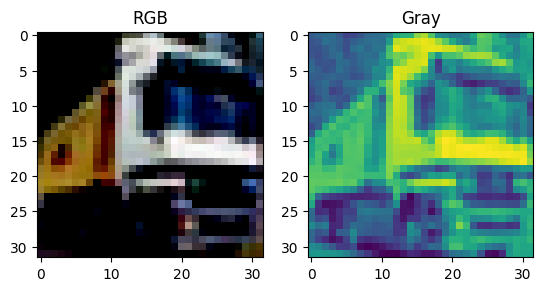

In [83]:
f, ax = plt.subplots(1,2)
rotated = ndimage.rotate(cifar_train_dataset[1][0].T, 270)
rotated_g = ndimage.rotate(cifar_train_dataset_g[1][0].T, 270)
ax[0].imshow(rotated)
ax[1].imshow(rotated_g)
ax[0].set_title('RGB'), ax[1].set_title('Gray')

In [84]:
# defining function to plot images pair
def plot_images(color,grayscale):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    rotated = ndimage.rotate(color, 270)
    plt.imshow(rotated)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    rotated_g = ndimage.rotate(grayscale, 270)
    plt.imshow(rotated_g, cmap='gray')

    plt.show()

In [85]:
print(train_loader)

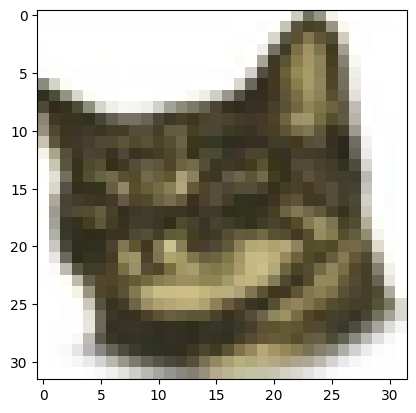

In [86]:
plt.imshow(ndimage.rotate(train_dataset[0][0].T, 270))

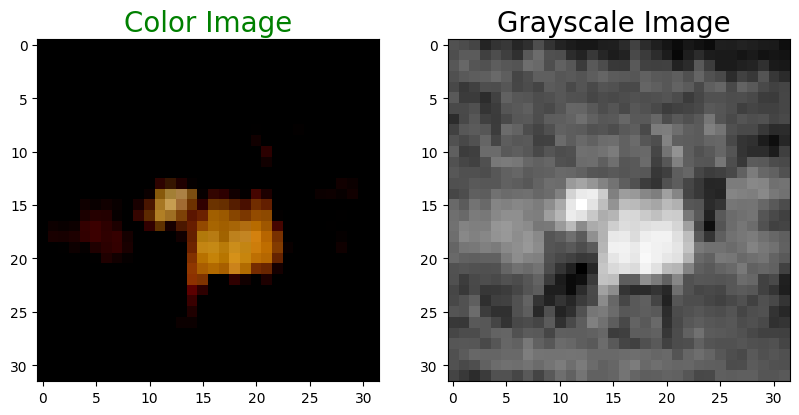

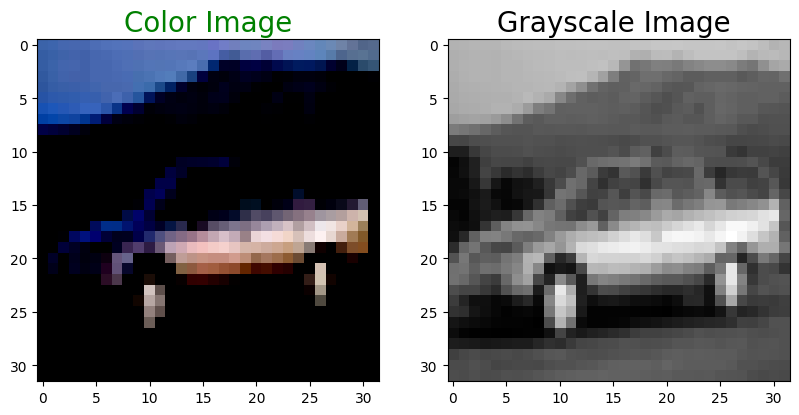

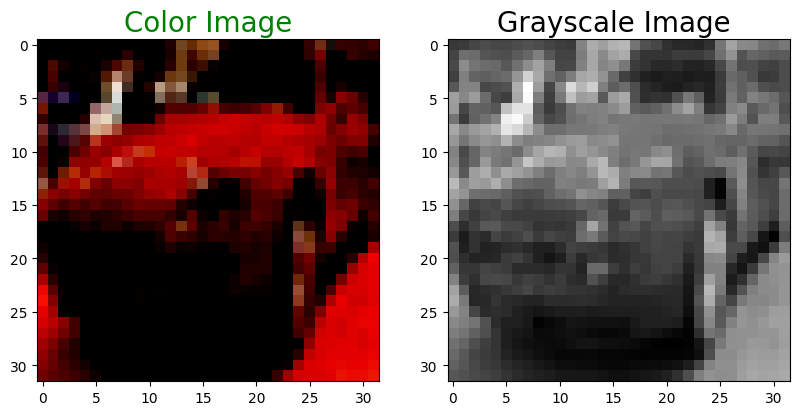

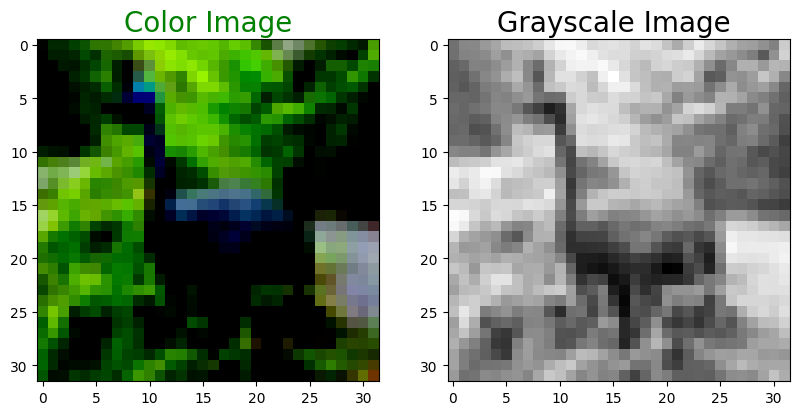

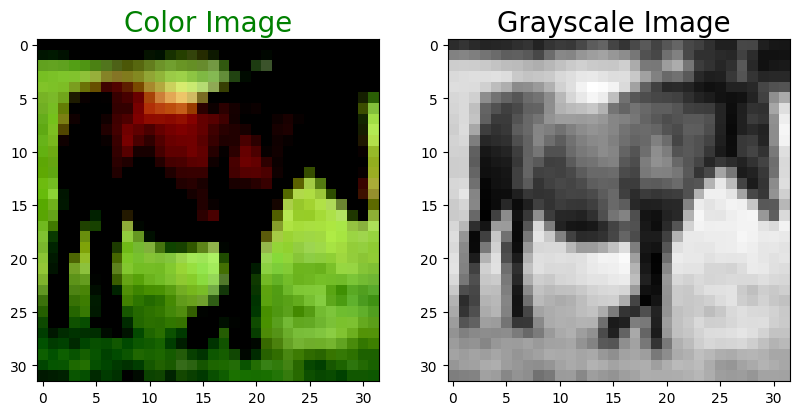

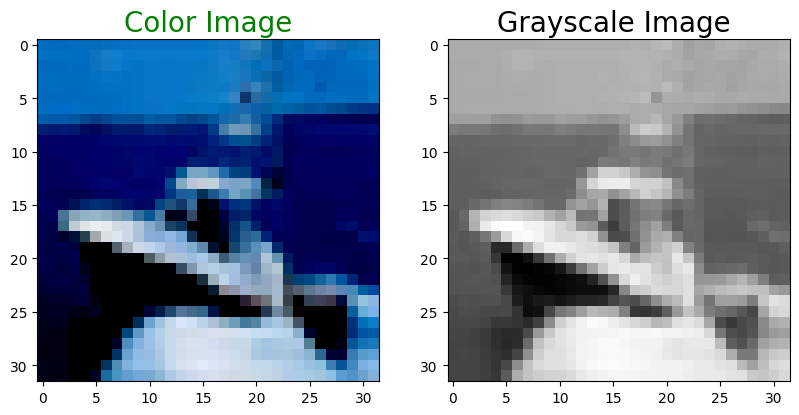

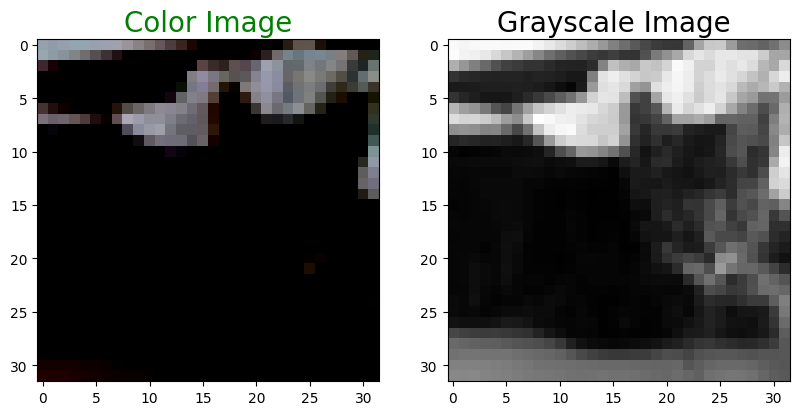

In [87]:
for i in range(3,10):
     plot_images(cifar_train_dataset[i][0].T,cifar_train_dataset_g[i][0].T)

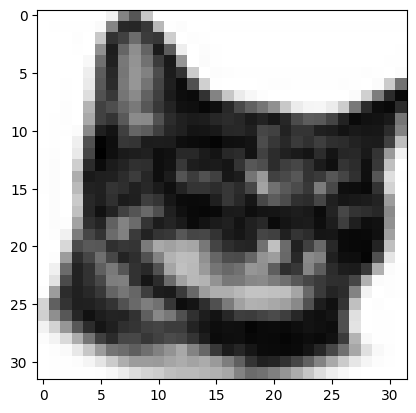

In [88]:
# plot images to check if dataset is correct
plt.imshow(x_train_tensor_g[0][0].cpu().data.numpy(), cmap='gray')

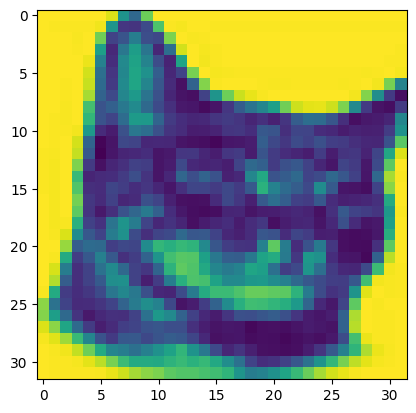

In [89]:
plt.imshow(x_train_tensor[0][0].cpu().data.numpy())

In [90]:
# Function that converts an image from RGB to YCbCr
def rgb_to_ycbcr(rgb_images):

    num_images, height, width, channels = rgb_images.shape

    ycbcr_images = np.zeros_like(rgb_images)

    # luminance component
    luma = np.zeros((num_images, height, width))

    # chrominance components red and blue
    chroma_red = np.zeros_like(luma)
    chroma_blue = np.zeros_like(luma)

    for i in range(num_images):
        ycbcr_images[i] = cv2.cvtColor(rgb_images[i], cv2.COLOR_RGB2YCrCb)
        # Extract Y, Cblue, and Cred channels
        luma[i], chroma_red[i], chroma_blue[i] = cv2.split(ycbcr_images[i])

    # Concatenate Cr and Cb
    chroma = np.concatenate((chroma_red[:, :, np.newaxis], chroma_blue[:, :, np.newaxis]), axis=2)

    return luma, chroma  # luma -> gray


# Function that converts an image from YCbCr to RGB
def ycbcr_to_rgb(ycbcr_images):

    num_images, height, width, channels = ycbcr_images.shape
    rgb_images = np.zeros_like(ycbcr_images)

    for i in range(num_images):
        ycbcr_image_float32 = ycbcr_images[i].astype(np.float32)
        rgb_images[i] = cv2.cvtColor(ycbcr_image_float32, cv2.COLOR_YCrCb2RGB)

    return rgb_images

In [91]:
print(x_train_tensor.shape)

torch.Size([48000, 3, 32, 32])


In [92]:
# Split our train, test and validation data
x_train_permuted = x_train_tensor.permute(0,2,3,1)
x_test_permuted = x_test_tensor.permute(0,2,3,1)
x_valid_permuted = x_valid_tensor.permute(0,2,3,1)
print(x_train_permuted.shape)
x_train_gray, x_train_chroma = rgb_to_ycbcr(x_train_permuted.numpy())
x_test_gray, x_test_chroma = rgb_to_ycbcr(x_test_permuted.numpy())
x_valid_gray, x_valid_chroma = rgb_to_ycbcr(x_valid_permuted.numpy())



torch.Size([48000, 32, 32, 3])


In [93]:
print(x_train_gray.shape)
print(x_train_chroma.shape)
print(x_test_gray.shape)

(48000, 32, 32)
(48000, 32, 2, 32)
(6000, 32, 32)


In [94]:
# Function that completeley reconstructs an image from the luminance and chrominance components
def image_reconstruction(luma, chroma):
    reconstructed_images = np.concatenate((luma, chroma), axis=3) #, axis=3
    reconstructed_images = ycbcr_to_rgb(reconstructed_images)
    return reconstructed_images

In [95]:
# Turn into float32
x_train_gray = np.float32(x_train_gray)
x_train_chroma = np.float32(x_train_chroma)
x_valid_gray = np.float32(x_valid_gray)
x_valid_chroma = np.float32(x_valid_chroma)
x_test_gray = np.float32(x_test_gray)
x_test_chroma = np.float32(x_test_chroma)

In [96]:
print(x_train_chroma.shape)
print(x_test_chroma.shape)
print(x_test_gray.shape)

(48000, 32, 2, 32)
(6000, 32, 2, 32)
(6000, 32, 32)


In [97]:
# Preprocessing of x for fitting the model for exercise 3
x_train_final = x_train_gray.reshape(list(x_train_gray.shape) + [1])
x_train_final = torch.from_numpy(x_train_final).permute(0,3,1,2)
x_train_chroma = torch.from_numpy(x_train_chroma).permute(0,2,1,3)
x_valid_final = x_valid_gray.reshape(list(x_valid_gray.shape) + [1])
x_valid_final = torch.from_numpy(x_valid_final).permute(0,3,1,2)
x_valid_chroma = torch.from_numpy(x_valid_chroma).permute(0,2,1,3)
x_test_final = x_test_gray.reshape(list(x_test_gray.shape) + [1])
x_test_final = torch.from_numpy(x_test_final).permute(0,3,1,2)
x_test_chroma = torch.from_numpy(x_test_chroma).permute(0,2,1,3)

In [98]:
print(x_train_final.shape)
print(x_valid_final.shape)
print(x_test_final.shape)
print(x_train_chroma.shape)
print(x_valid_chroma.shape)
print(x_test_chroma.shape)

torch.Size([48000, 1, 32, 32])
torch.Size([6000, 1, 32, 32])
torch.Size([6000, 1, 32, 32])
torch.Size([48000, 2, 32, 32])
torch.Size([6000, 2, 32, 32])
torch.Size([6000, 2, 32, 32])


## 3.1 First model for colorization
We start by modifying our best performing (model_1 with fewer layers). The modification lies in the number of input channels for the first layer (now 1 instead of 3) and the number of output channels in the last layer (now 2 instead of 3 because of chrominance). We can see from the error after training and the plots of the reconstructed image that our model does a fairly good job regarding colorization. We can see that the shapes of recosntructed image are distinguishable and the colors are fairly accurate. The original image however has brighter colors and sharper edges.

In [99]:
# Creating model with fewer intermediate layers
class ConvAutoencoderReducedGray(nn.Module):
  def __init__(self):
    super(ConvAutoencoderReducedGray, self).__init__()

    # First conv-pool block
    self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    # Second conv-pool block
    self.conv2 = nn.Conv2d(8, 12, kernel_size=3, stride=1, padding=1)

    # Upsampling layer
    self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

    # Third conv-pool block (Note: Adjusted channels for compatibility)
    self.conv3 = nn.Conv2d(12, 2, kernel_size=3, stride=1, padding=1)


  def forward(self, x):
    # Encoder
    x = F.relu(self.conv1(x))
    x = self.pool1(x)
    x = F.relu(self.conv2(x))

    # Decoder
    x = self.upsample(x)
    x = F.relu(self.conv3(x))

    return x

model_1_gray = ConvAutoencoderReducedGray().to(device)

In [100]:
# Define the loss function, accuracy and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model_1_gray.parameters(), lr=0.001)

In [101]:
print(x_train_final.shape)
print(x_train_chroma.shape)

torch.Size([48000, 1, 32, 32])
torch.Size([48000, 2, 32, 32])


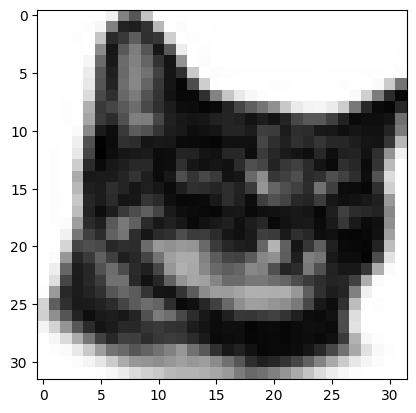

In [102]:
plt.imshow(x_train_final[0][0].cpu().data.numpy(), cmap='gray')

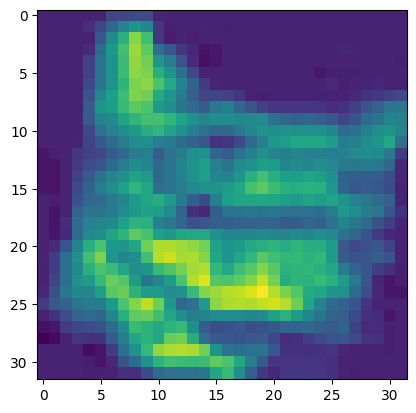

In [103]:
plt.imshow(x_train_chroma[0][0].cpu().data.numpy())

In [104]:
# define dataloader that contains the grayscale and colourized training/testing set
dataset_train = torch.utils.data.TensorDataset(x_train_final, x_train_chroma)
dataset_test = torch.utils.data.TensorDataset(x_test_final, x_test_chroma)

train_dataloader_gray = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader_gray = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

In [105]:
torch.manual_seed(42)
epochs = 20

train_losses = []
test_losses = []



# Create training and test loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-------")
  ### Training
  train_loss = 0
  # Add a loop to loop through the training batches
  for batch, (inp, out)in enumerate(train_dataloader_gray):
    X = inp.to(device)
    out_train = out.to(device)
    if batch == 1 and epoch == 1:
      print(f'Input shape: {X.shape}')
      print(f'Output shape: {out_train.shape}')
    model_1_gray.train()
    # 1. forward pass
    reconstructed = model_1_gray(X)

    # 2. Calculate loss (batch)
    loss = criterion(reconstructed, out_train)
    train_loss += loss.item() #  accumulate train loss

    # 3. optimizer zero grad
    optimizer.zero_grad()

    # 4. loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Print out
    if batch % 200 == 0:
      print(f"Looked at {batch * len(X)}/{len(train_dataloader_gray.dataset)} samples.")
  # Divide total train loss by length of train dataloader
  train_loss /= len(train_loader)
  train_losses.append(train_loss)



### Testing
  test_loss = 0
  model_1_gray.eval()
  with torch.inference_mode():
    for X_test, out_test in test_dataloader_gray:
      X_test = X_test.to(device)
      out_test = out_test.to(device)
      if batch == 1:
        print(f'Input test shape: {X_test.shape}')
        print(f'Output test shape: {out_test.shape}')
      # 1. Forward pass
      test_reconstructed = model_1_gray(X_test)


      # 2. Calculate loss (accumulatively)
      test_loss += criterion(test_reconstructed, out_test).item()

    # Calculate the test loss average per batch
    test_loss /= len(test_loader)
    test_losses.append(test_loss)

  # Print
  print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/48000 samples.

Train loss: 0.0492 | Test loss: 0.0106
Epoch: 1
-------
Looked at 0/48000 samples.
Input shape: torch.Size([1024, 1, 32, 32])
Output shape: torch.Size([1024, 2, 32, 32])

Train loss: 0.0090 | Test loss: 0.0075
Epoch: 2
-------
Looked at 0/48000 samples.

Train loss: 0.0062 | Test loss: 0.0054
Epoch: 3
-------
Looked at 0/48000 samples.

Train loss: 0.0050 | Test loss: 0.0046
Epoch: 4
-------
Looked at 0/48000 samples.

Train loss: 0.0044 | Test loss: 0.0042
Epoch: 5
-------
Looked at 0/48000 samples.

Train loss: 0.0041 | Test loss: 0.0040
Epoch: 6
-------
Looked at 0/48000 samples.

Train loss: 0.0039 | Test loss: 0.0038
Epoch: 7
-------
Looked at 0/48000 samples.

Train loss: 0.0038 | Test loss: 0.0037
Epoch: 8
-------
Looked at 0/48000 samples.

Train loss: 0.0037 | Test loss: 0.0037
Epoch: 9
-------
Looked at 0/48000 samples.

Train loss: 0.0036 | Test loss: 0.0036
Epoch: 10
-------
Looked at 0/48000 samples.

Train loss: 0.0036 | Test l

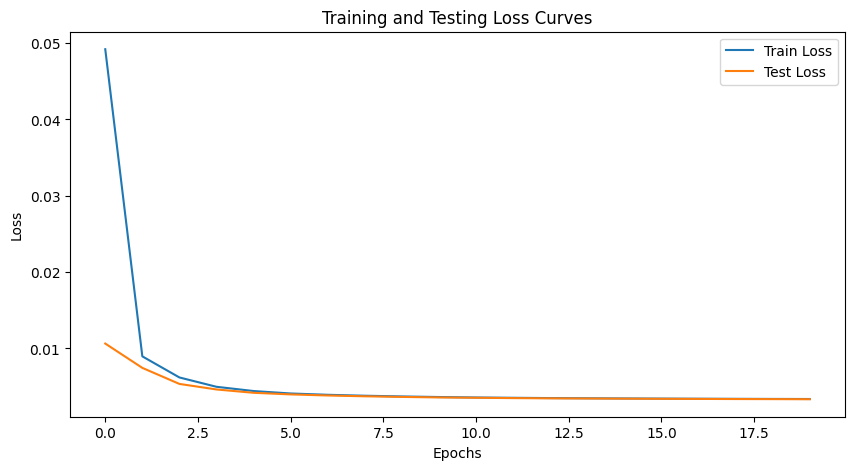

In [106]:
# Plotting the curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Testing Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

(6000, 32, 32)


Text(0.5, 1.0, 'Grayscale')

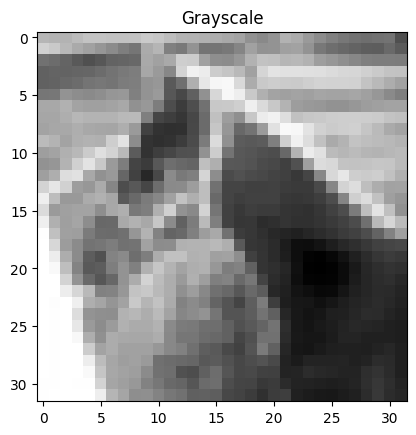

In [107]:
# plot real grayscale image
print(x_test_gray.shape)
plt.imshow(x_test_gray[1], cmap='gray')
plt.title('Grayscale')

In [108]:
# plot reconstructed image
x_prediction = model_1_gray(x_test_final.to(device))
print(x_prediction.shape)
print(x_test_final.shape)
x_prediction = x_prediction.permute(0,2,3,1)
x_test_final_1 = x_test_final.permute(0,2,3,1)
x_prediction = x_prediction.cpu().data.numpy()
x_test_final_1 = x_test_final_1.detach().numpy()
test_reconstructed = image_reconstruction(x_test_final_1, x_prediction)

torch.Size([6000, 2, 32, 32])
torch.Size([6000, 1, 32, 32])


Text(0.5, 1.0, 'Reconstruction')

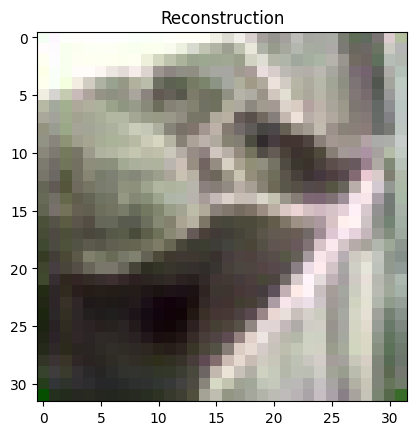

In [109]:
# plot reconstructed image
plt.imshow(ndimage.rotate(test_reconstructed[1], 270))
plt.title('Reconstruction')

Text(0.5, 1.0, 'Ground truth')

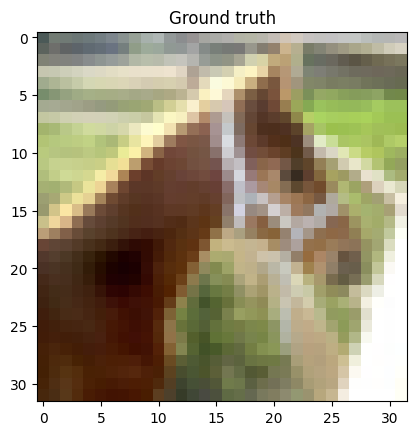

In [110]:
# Plot original test image
X_test_cpu = x_test_tensor.cpu().data.numpy()
plt.imshow(ndimage.rotate(X_test_cpu[1].T, 270))
plt.title('Ground truth')

## 3.2 Try a second model for colorization
In the second part of exercise 3 we want to report on the potential shortcomings of our network. We further introduce a second model to see if our shortcomings translate into a different architecture as well.

We first see from the results of our first model that the overall representation of the input image is not as sharp as the original image. This can be due to the chrominance trick but could also be an indicator that our model architecture is not complex enough to learn an accurate representation of the data. Also the brightness of the colors is not as good as in the original image. This may be because of too less training samples which prevent learning the original colors accurately and keep model somewhat "stuck" at the influence of the grayscale input.

In [111]:
# Modify model_2 for colorization
class ConvAutoencoderChannelsGray(nn.Module):
    def __init__(self):
        super(ConvAutoencoderChannelsGray, self).__init__()

        # First conv-pool block
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Second conv-pool block
        self.conv2 = nn.Conv2d(16, 24, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Third conv-pool block
        self.conv3 = nn.Conv2d(24, 32, kernel_size=3, stride=1, padding=1)

        # Upsampling layer
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

        # Fourth conv-pool block
        self.conv4 = nn.Conv2d(32, 24, kernel_size=3, stride=1, padding=1)

        # Upsampling layer
        self.upsample2 = nn.Upsample(scale_factor=2, mode='nearest')

        # Fifth conv-pool block
        self.conv5 = nn.Conv2d(24, 2, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        # Encoder
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))


        # Decoder
        x = self.upsample(x)
        x = F.relu(self.conv4(x))
        x = self.upsample2(x)
        x = F.relu(self.conv5(x))

        return x

# Instantiate the model
model_2_gray = ConvAutoencoderChannelsGray().to(device)

In [112]:
# Define the loss function, accuracy and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model_2_gray.parameters(), lr=0.001)

In [113]:
torch.manual_seed(42)
epochs = 20

train_losses = []
test_losses = []



# Create training and test loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-------")
  ### Training
  train_loss = 0
  # Add a loop to loop through the training batches
  for batch, (inp, out)in enumerate(train_dataloader_gray):
    X = inp.to(device)
    out_train = out.to(device)
    if batch == 1 and epoch == 1:
      print(f'Input shape: {X.shape}')
      print(f'Output shape: {out_train.shape}')
    model_2_gray.train()
    # 1. forward pass
    reconstructed = model_2_gray(X)

    # 2. Calculate loss (batch)
    loss = criterion(reconstructed, out_train)
    train_loss += loss.item() #  accumulate train loss

    # 3. optimizer zero grad
    optimizer.zero_grad()

    # 4. loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Print out
    if batch % 200 == 0:
      print(f"Looked at {batch * len(X)}/{len(train_dataloader_gray.dataset)} samples.")
  # Divide total train loss by length of train dataloader
  train_loss /= len(train_loader)
  train_losses.append(train_loss)



### Testing
  test_loss = 0
  model_2_gray.eval()
  with torch.inference_mode():
    for X_test, out_test in test_dataloader_gray:
      X_test = X_test.to(device)
      out_test = out_test.to(device)
      if batch == 1:
        print(f'Input test shape: {X_test.shape}')
        print(f'Output test shape: {out_test.shape}')
      # 1. Forward pass
      test_reconstructed = model_2_gray(X_test)


      # 2. Calculate loss (accumulatively)
      test_loss += criterion(test_reconstructed, out_test).item()

    # Calculate the test loss average per batch
    test_loss /= len(test_loader)
    test_losses.append(test_loss)

  # Print
  print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/48000 samples.

Train loss: 0.0625 | Test loss: 0.0119
Epoch: 1
-------
Looked at 0/48000 samples.
Input shape: torch.Size([1024, 1, 32, 32])
Output shape: torch.Size([1024, 2, 32, 32])

Train loss: 0.0076 | Test loss: 0.0052
Epoch: 2
-------
Looked at 0/48000 samples.

Train loss: 0.0043 | Test loss: 0.0037
Epoch: 3
-------
Looked at 0/48000 samples.

Train loss: 0.0036 | Test loss: 0.0035
Epoch: 4
-------
Looked at 0/48000 samples.

Train loss: 0.0035 | Test loss: 0.0034
Epoch: 5
-------
Looked at 0/48000 samples.

Train loss: 0.0034 | Test loss: 0.0034
Epoch: 6
-------
Looked at 0/48000 samples.

Train loss: 0.0034 | Test loss: 0.0034
Epoch: 7
-------
Looked at 0/48000 samples.

Train loss: 0.0034 | Test loss: 0.0033
Epoch: 8
-------
Looked at 0/48000 samples.

Train loss: 0.0034 | Test loss: 0.0034
Epoch: 9
-------
Looked at 0/48000 samples.

Train loss: 0.0033 | Test loss: 0.0033
Epoch: 10
-------
Looked at 0/48000 samples.

Train loss: 0.0033 | Test l

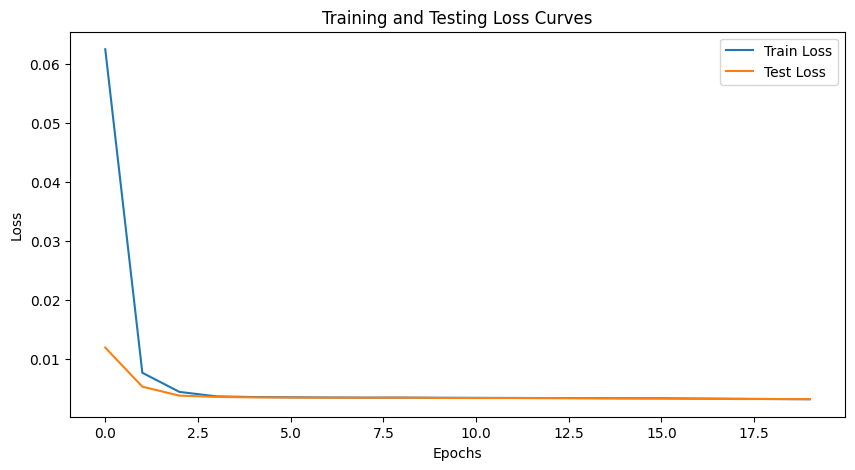

In [114]:
# Plotting the curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Testing Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Model 2 results
We can see very similar results with our second model for colorization (Second best model from first part of the assignment). This model has more layers and therefore a more complex architecture. We can see from error after training that it learns the colorization slightly better than the first model which indicates that our assumption of the possible shortcomings of the first model might be true. However, when viewing the plot of the reconstructed image we can not clearly identify an improvement and see similar results.

(6000, 32, 32)


Text(0.5, 1.0, 'Grayscale')

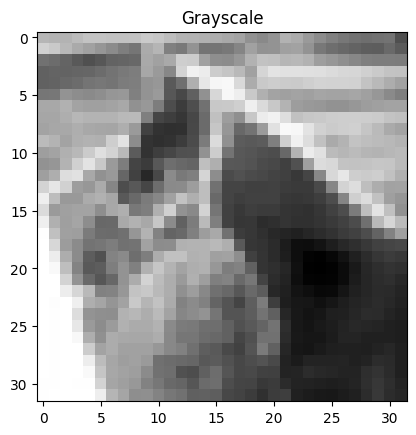

In [115]:
# plot real grayscale image
print(x_test_gray.shape)
plt.imshow(x_test_gray[1], cmap='gray')
plt.title('Grayscale')

In [116]:
# plot reconstructed image
x_prediction = model_2_gray(x_test_final.to(device))
print(x_prediction.shape)
print(x_test_final.shape)
x_prediction = x_prediction.permute(0,2,3,1)
x_test_final_2 = x_test_final.permute(0,2,3,1)
x_prediction = x_prediction.cpu().data.numpy()
x_test_final_2 = x_test_final_2.detach().numpy()
test_reconstructed = image_reconstruction(x_test_final_2, x_prediction)

torch.Size([6000, 2, 32, 32])
torch.Size([6000, 1, 32, 32])


Text(0.5, 1.0, 'Reconstruction')

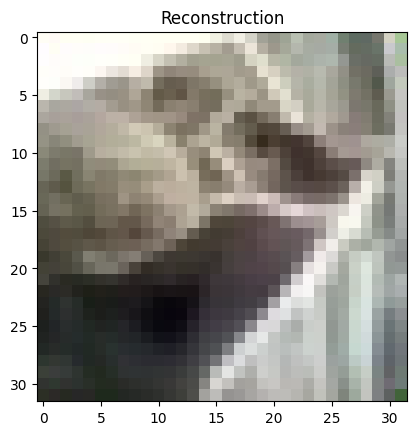

In [117]:
# plot reconstructed image
plt.imshow(ndimage.rotate(test_reconstructed[1], 270))
plt.title('Reconstruction')

Text(0.5, 1.0, 'Ground truth')

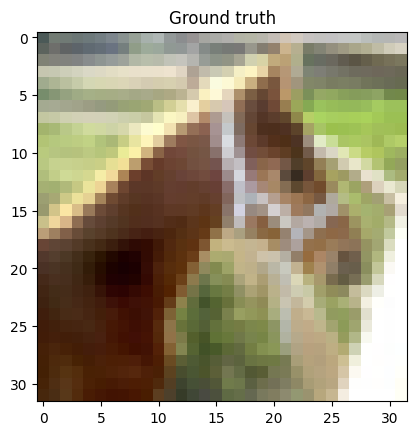

In [118]:
# Plot original test image
X_test_cpu = x_test_tensor.cpu().data.numpy()
plt.imshow(ndimage.rotate(X_test_cpu[1].T, 270))
plt.title('Ground truth')